In [2]:

import subprocess

import whisper
from fairseq.models.transformer import TransformerModel

import time
from pythainlp import word_tokenize
import pythainlp

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import re
import requests
from rembg import remove
import numpy as np
from PIL import Image

import easyocr
import cv2

import math



en2th_spm = TransformerModel.from_pretrained(
    model_name_or_path='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/models/',
    checkpoint_file='checkpoint.pt',
    data_name_or_path='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/vocab/',
    bpe='sentencepiece',
    sentencepiece_model='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/bpe/spm.en.model'
)

        
    
class MYWordcloud:
    
    en2th_spm = TransformerModel.from_pretrained(
    model_name_or_path='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/models/',
    checkpoint_file='checkpoint.pt',
    data_name_or_path='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/vocab/',
    bpe='sentencepiece',
    sentencepiece_model='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/bpe/spm.en.model'
    )
    
    def __init__(self,url: str,whisper_modelsize = "medium",namepath ="video.mp4") -> None:
        self.url = url
        self.namepath = namepath
        self.download_video(self.url,self.namepath)
        self.whisper_modelsize = whisper_modelsize
        self.transcribe, self.language = self.transcribe_audio(self.namepath,self.whisper_modelsize)
        self.en_text_fromaudio = self.transcribe["text"]
        
        text = ""
        for i in range(len(self.transcribe["segments"])):
            text += self.translate(self.transcribe["segments"][i]["text"])
        self.th_text_fromaudio = text
        
        self.data_fromvideo = self.open_video(self.namepath)
        
    @staticmethod
    def download_video(url,namepath):
    command = [
        "yt-dlp",  
        "-f", "mp4",
        "-o",namepath, 
        url,  
        ]
    try:
        subprocess.run(command, check=True)
        print(f"Download video completed ")
    except subprocess.CalledProcessError as e:
        print(f"Error downloading video: {e}")
        
    @staticmethod
    def transcribe_audio(namepath,whisper_modelsize="small"):
        model = whisper.load_model(whisper_modelsize)
        audio = whisper.load_audio(namepath)
        audio = whisper.pad_or_trim(audio)


        mel = whisper.log_mel_spectrogram(audio).to(model.device)


        _, probs = model.detect_language(mel)
        language = max(probs, key=probs.get)
        if language != "en":
            sentence = model.transcribe(namepath, language="en", task="translate")
        else:
            sentence = model.transcribe(namepath)
        return (sentence ,language)
        
    @staticmethod
    def translate(input_sentence):
        return en2th_spm.translate(input_sentence)
        
    @staticmethod
    def show_thumbnail(url,bw=False):
        #เอา youtube id
        match = re.search(r'v=([^&]+)', url)
        if match:
            youtube_id =  match.group(1)
            
        thumbnail_url = f'https://img.youtube.com/vi/{youtube_id}/maxresdefault.jpg'
        #เขียนไฟล์จ้า
        im_namefile = "thumbnail.jpg"
        response = requests.get(thumbnail_url)
        if response.status_code == 200:
            with open(im_namefile, 'wb') as f:
                f.write(response.content)
                print("ดาวน์โหลดรูปปกเสร็จเรียบร้อยแล้ว!")
        else:
                print("ไม่สามารถดาวน์โหลดรูปปกได้")
        
        mask_img = Image.open(im_namefile).convert("RGBA")

        if bw == False:
            return mask_img
        else:
            mask_img = Image.open(im_namefile).convert("RGBA")
            mask_img = remove(mask_img)
            mask_img.getpixel((0,0))
            x,y = mask_img.size
            for i in range(x):
                for j in range(y):
                    if mask_img.getpixel((i,j))[3] == 0:
                        mask_img.putpixel((i,j),(255,255,255,255))
                    else:
                        mask_img.putpixel((i,j),(0,0,0,0))
            return mask_img
        
    @staticmethod
    def open_video(path):
        reader = easyocr.Reader(['en',"th"])  
        video_capture = cv2.VideoCapture(path)

        text_data  = []
        frame_data = []
        while video_capture.isOpened():
            ret, frame = video_capture.read()
            if not ret:
                break
        
            current_frame = int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))
            if current_frame % 2 != 0:
                continue
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            results = reader.readtext(gray)
            #results = reader.readtext(frame)
            for (bbox, text, prob) in results:
                text = text.lower().strip().replace(" ", "")
                (top_left, top_right, bottom_right, bottom_left) = bbox
                x1 , y1= top_left
                x2 , y2 = bottom_right
                
                cv2.rectangle(frame, (int(x1),int(y1)), (int(x2),int(y2)), (0, 255, 0), 2)
                cv2.putText(frame, f"{text}:{round(prob,3)}", (int(x1),int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
                if prob > 0.30 and all(text != item[0] for item in text_data):
                    text_data.append([text,MYWordcloud.translate(text) ,1])
                    frame_data.append([[current_frame], [frame]])
                else:
                    for i in range(0, len(text_data)):
                        if text_data[i][0] == text:
                            text_data[i][2] += 1
                            frame_data[i][0].append(current_frame)
                            frame_data[i][1].append(frame)
            cv2.imshow("frame", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        video_capture.release()
        cv2.destroyAllWindows()
        tu = []
        for i in range(0, len(text_data)):
            tu.append([text_data[i][1],frame_data[i][1]])
        return tu
    
    def lyrics(self):
        for i in range(len(self.transcribe["segments"])):
            print(self.transcribe["segments"][i]["text"])
            sleep_time = self.transcribe["segments"][i]["end"] - self.transcribe["segments"][i]["start"]
            time.sleep(sleep_time)
    
    def detect(self, text):
        for i in range(len(self.data_fromvideo)):
            if text == self.data_fromvideo[i][0]:
                frames = self.data_fromvideo[i][1]
                num_frames = len(frames)
                break
        else:
            print(f"No data found for text: {text}")
            return

        grid_size = math.ceil(math.sqrt(num_frames))

        fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
        axs = np.atleast_1d(axs).flatten()

        for i in range(num_frames):
            axs[i].imshow(frames[i])
            axs[i].axis("off")

        for j in range(num_frames, grid_size * grid_size):
            axs[j].axis("off")

        plt.tight_layout()
        plt.show()

    
    def show(self, mask=True):
        wc_list = []
        list_word = word_tokenize(self.th_text_fromaudio)  
        text1 = " ".join(list_word).lower().strip()  
        text2 = ""
        
        for st in self.data_fromvideo:
            for i in range(len(st)):  
                text2 += st[0].replace(" ", "") + " "
        
        text_list = [text1, text2]
        
        for text in text_list:
            if mask:
                mask_img = np.array(self.show_thumbnail(self.url, bw=True))  
                wc_list.append(WordCloud(
                    font_path="D:\summer\opas v.2\THSarabunNew.ttf",
                    regexp="[ก-๙]+",
                    width=2000, height=1000,
                    prefer_horizontal=1,
                    stopwords=set(pythainlp.corpus.thai_stopwords()),
                    max_words=50,
                    colormap="viridis",
                    background_color="white",
                    mask=mask_img).generate(text))
            else:
                wc_list.append(WordCloud(
                    font_path="D:\summer\opas v.2\THSarabunNew.ttf",
                    regexp="[ก-๙]+",
                    width=2000, height=1000,
                    prefer_horizontal=1,
                    stopwords=set(pythainlp.corpus.thai_stopwords()),
                    max_words=50,
                    colormap="viridis",
                    background_color="white").generate(text))


        if len(wc_list) >= 2:
            fig, ax = plt.subplots(1, 2, figsize=(15,15))
            ax[0].imshow(wc_list[0])
            ax[0].axis("off")
            ax[0].set_title("Audio")
            ax[1].imshow(wc_list[1])
            ax[1].axis("off")
            ax[1].set_title("Video")
            plt.show()
        else:
            print("Not enough word clouds generated to display.")


        


2024-06-27 18:16:40 | INFO | fairseq.file_utils | loading archive file mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/models/
2024-06-27 18:16:40 | INFO | fairseq.file_utils | loading archive file mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/vocab/
2024-06-27 18:16:42 | INFO | fairseq.tasks.translation | [en] dictionary: 29208 types
2024-06-27 18:16:42 | INFO | fairseq.tasks.translation | [th] dictionary: 29208 types
2024-06-27 18:16:43 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': './checkpoints/5.5.2020_v2/en-th/spm-spm/32000-joined/log', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'f

In [4]:
v =MYWordcloud("https://www.youtube.com/watch?v=TsKHjFeonRE&t=36s",whisper_modelsize="medium")

Download video completed 


d:\Programs\anaconda\envs\t2\lib\site-packages\fairseq\models\transformer\transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  x = torch._nested_tensor_from_mask(


In [29]:
v.show(mask=Ture)

NameError: name 'Ture' is not defined

In [31]:
v.show_thumbnail(v.url,bw=True)

ConnectionError: HTTPSConnectionPool(host='img.youtube.com', port=443): Max retries exceeded with url: /vi/TsKHjFeonRE/maxresdefault.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000023380A481F0>: Failed to resolve 'img.youtube.com' ([Errno 11001] getaddrinfo failed)"))

In [19]:
v.th_text_fromaudio

'เมื่อวาน Apple เปิดตัวเทคโนโลยีการคํานวณล่าสุดไม่ฉันไม่ได้พูดถึงดินสอ $ 129 ใหม่หรือแป้นพิมพ์ $ 299 ใหม่และมันไม่ใช่รถไฟฟ้าใหม่ที่ชาร์จจากด้านล่างมันเป็นชิป M4 ใหม่ซึ่ง Apple อ้างว่าเป็นชิปที่ยิ่งใหญ่ที่สุดและแย่ที่สุดที่ตลาดพีซีเคยเห็นCPU ของมันเร็วกว่า M2 50% มันได้รับการ Tracing ray ในตัวและเครื่องยนต์ประสาทสามารถรองรับการดําเนินงานที่ไร้สาระ 38 ล้านล้านครั้งต่อวินาทีทําให้ชิปที่เร็วที่สุดสําหรับภาระงาน AI ในตลาดพีซีในวันนี้สิ่งที่น่าสนใจคือ Apple เลือกที่จะเปิดตัว M4 เมื่อวานนี้ที่งาน iPadและไม่ใช่การประชุมนักพัฒนาทั่วโลกซึ่งอยู่ห่างออกไปเพียงหนึ่งเดือนสิ่งที่คุณอาจไม่ทราบคือเราอยู่ตรงกลางของการแข่งขันแขนการแข่งขันระดับโลกเพื่อสร้างชิปที่อิง ARM ที่ดีที่สุดและครองโลกแต่ตะกั่วของ Apple อาจไม่นานในวิดีโอของวันนี้เราจะดูที่ผู้เล่นรายใหญ่และความหมายทั้งหมดสําหรับอนาคตของเทคโนโลยีการคํานวณมันคือวันที่ 8 พฤษภาคม 2024 และคุณกําลังดูรายงานรหัสทุกคนที่ฉันรู้คือการสร้างชิป ARMSamsung, Google, Microsoft และแม้กระทั่ง Intel จะเข้าร่วมการแข่งขันด้านอาวุธแต่รอสักครู่ ARM คืออะไรในอดีตแล้วคอมพิว

In [21]:
v.lyrics()

 Yesterday, Apple unveiled its latest marvel of computing technology.
 No, I'm not talking about its new $129 pencil, or its new $299 keyboard,
 and it's not a new electric car that charges from the bottom.
 It's the new M4 chip, which Apple claims is the biggest and baddest chip the PC market has ever seen.
 Its CPU is 50% faster than the M2, it's got built-in ray tracing,
 and the neural engine can handle a ridiculous 38 trillion operations per second,
 making it the fastest chip for AI workloads on the PC market today.
 What's interesting though is that Apple chose to unveil M4 yesterday at its iPad event,


KeyboardInterrupt: 

In [17]:
print([i[0] for i in v.data_fromvideo ])

['จําลอง', 'กับ', 'ไพธอนเทอร์เทิล', 'คอนโซล', 'เปลือก', 'เบอร์โทรศัพท์', 'ของ', 'อิเล็กตรอน:', 'ที', '1', 'แอล', 'อิเล็กตรอน', 'ซิมูลาคอร์', 'ผู้จําลอง', 'ตัวจําลองอิเล็กตรอน', 'อิเล็กตรอน.', 'จําลองอ่ะ', 'ตัวจําลองอิเล็กตรอน', 'เลทรอน ผู้จําลอง', 'ตัวจําลองอิเล็กตรอน', 'ผู้จําลองระดับปริญญาตรี', 'ผู้บังคับการ', 'สุลต่าม', 'แบ็กตรอน', 'สเตมูเลเตอร์ค่ะ', 'etectron', 'ราเลเตอร์', 'ซินัลเตอร์', 'นาเลเตอร์', 'สอง', 'อิครอน', 'ซิulator', 'เย็น', 'เลคทรอน', 'ไฟฟ้า', '3', '(ถอนหายใจ)', 'อิเล็กตรอน', 'อูเอเตอร์', 'ขั้วไฟฟ้า', 'มัลเตอร์', 'การจําลอง', 'เลกตรอน', 'ซิมมูล', 'พรุ่งนี้', '5', 'เอเลก รอน', 'ตัวจําลองสัญญาณไฟฟ้า', 'ตัวจําลอง Electton', 'เลือกตั้ง', 'อิเล็กตรอน_nulator', 'การจําลองอิเล็กตรอน', 'ตัวจําลองอิเล็กตรอน', 'ตัวจําลองการเรียน', 'น้องสาว', 'กําลังทําอยู่', 'เลียเตอร์', 'ผู้บังคับบัญชา เอลอีซี+', 'การจําลองเสียง', 'น้องสาว', 'แอลเอเตอร์', 'ริโมะ', 'เลือกตั้ง', 'อิเล็กตรอนจําลอง_', 'แบบจําลองอิเล็กตรอน', 'วิชาบังคับบัญชา', 'อิครอนค่ะ', 'การจําลองอิเล็กตรอน', 'อิเล็กตรอน simulaco

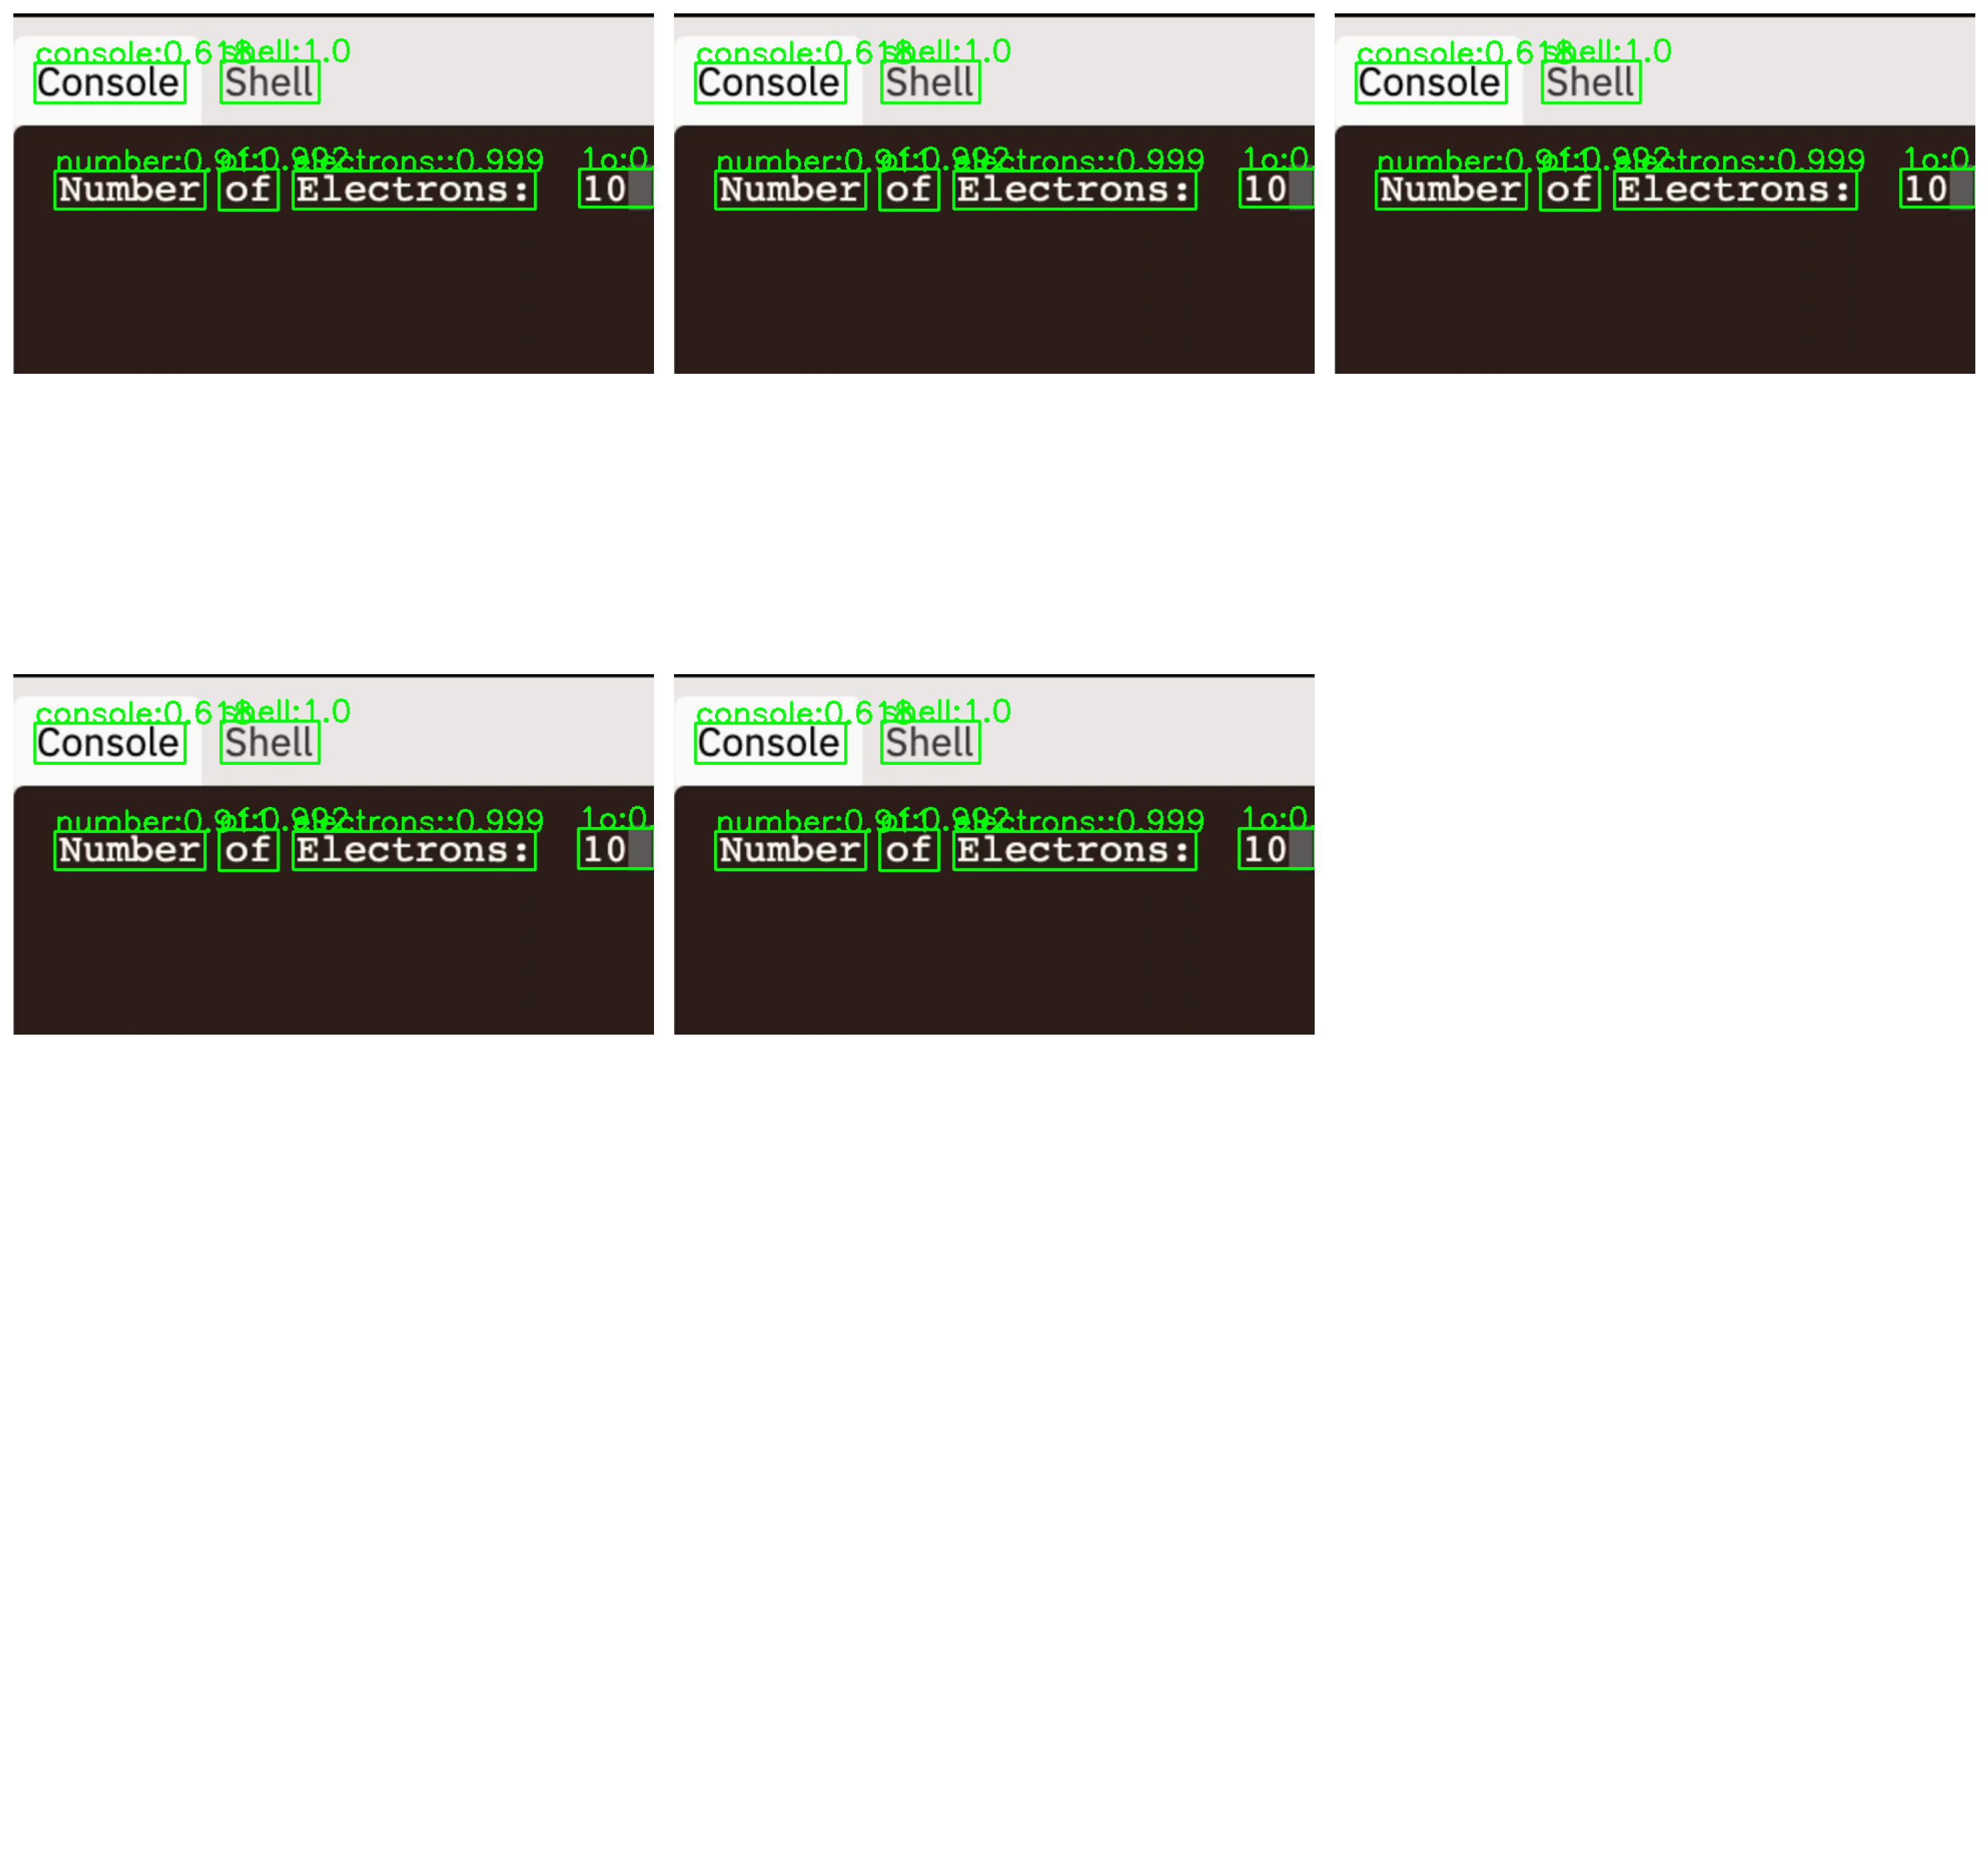

In [26]:
v.detect("บ่ายโมง")


In [ ]:

num_frames = len(frame_data[i][1])

grid_size = math.ceil(math.sqrt(num_frames))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axs = axs.flatten()  

for i in range(num_frames):
    axs[i].imshow(frame_data[0][1][i])  # Display the i-th frame
    axs[i].axis("off")

for j in range(num_frames, grid_size * grid_size):
    axs[j].axis("off")

plt.tight_layout()
plt.show()